In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import re
from matplotlib import pyplot as plt
import scipy.io as sio
import numpy as np
import pickle as pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from scipy import signal
import os
import math

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
# from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, Conv2D, MaxPooling2D, RepeatVector
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_path = '/content/drive/My Drive/Major/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Filtered_Data/'
channel_names = ['P4', 'Cz', 'F8', 'T7']  # Specify the EEG channel names

In [4]:
def load_eeg_data(directory, channel_names):
    data = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)

            df = pd.read_csv(filepath)

            num_rows = len(df)
            # If the number of rows is less than the specified maximum
            if num_rows < 24000:
                print(f"Skipping file {filename} as it doesn't have enough rows.")
                continue
            df = df.head(23800)

            eeg_data_per_file = []
            for channel_name in channel_names:
                if channel_name in df.columns:
                    eeg_data_per_file.append(df[channel_name].values)
                else:
                    print(f"Column '{channel_name}' not found in file {filename}. Skipping...")
                    eeg_data_per_file = None
                    break

            if eeg_data_per_file is None:
                continue

            eeg_data_per_file = np.array(eeg_data_per_file)  # Convert to numpy array
            data.append(eeg_data_per_file)

            # Extract label from filename
            person_id = 0
            match = re.search(r's(\d+)_ex', filename)
            if match:
                person_id = int(match.group(1))  # Convert the extracted number to an integer
            else:
                print("No match found.")
            label = person_id - 1
            # label = np.zeros(20, dtype=bool)  # 20 classes (persons)
            # label[person_id - 1] = 1
            labels.append(label)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [5]:
eeg_data, labels = load_eeg_data(dataset_path, channel_names)

print("EEG data shape:", eeg_data.shape)
print("Labels shape:", labels.shape)

Skipping file s03_ex06.csv as it doesn't have enough rows.
Skipping file s20_ex01_s03.csv as it doesn't have enough rows.
Skipping file s19_ex01_s03.csv as it doesn't have enough rows.
EEG data shape: (237, 4, 23800)
Labels shape: (237,)


In [6]:
eeg_Label = []
for i in labels:
    for j in range (0,4):
        eeg_Label.append(i)

In [7]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(eeg_Label)

y.shape

(948, 20)

In [8]:
import functools
def combine_dims(a, i=0, n=1):
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])

In [9]:
eeg_Data = combine_dims(np.array(eeg_data), 0)

eeg_Data.shape

(948, 23800)

In [10]:
fs = 200

size_dataset = len(eeg_Data)
nperseg = 400
noverlap = 200
f_size = math.ceil(((nperseg + 1)/2))
t_size = int((eeg_Data[0].size - noverlap ) / (nperseg - noverlap))
X_full = np.ndarray(shape=(size_dataset, f_size, t_size, 3))

for i in range(0, size_dataset):
  for j in range(0,3):
    X = eeg_Data[i]
    f, t, Sxx = spectrogram(X, fs, nperseg = nperseg, noverlap = noverlap, mode='psd')
    X_full[i, :, :, j] = Sxx

In [11]:
X_full = np.array(X_full)

X_full.shape

(948, 201, 118, 3)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

X_train /= 255
X_test /= 255

In [13]:
num_classes = 20

input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
input_shape

(201, 118, 3)

In [14]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on imbalance ratio
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)

# Convert class_weights array to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [21]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, RepeatVector, LSTM, Dense, Layer
import keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[0][-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[0][1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        lstm_output, _, _ = x
        et = K.squeeze(K.tanh(K.dot(lstm_output, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = lstm_output * at
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][-1])

# Define the model with the corrected Attention layer
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(inputs)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
lstm_output = LSTM(256, return_sequences=True, return_state=True, dropout=0.2)(x)
attention_output = Attention()(lstm_output)
dense_output = Dense(128, activation='relu')(attention_output)
outputs = Dense(num_classes, activation='softmax')(dense_output)
model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 201, 118, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 199, 116, 32)         896       ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 99, 58, 32)           0         ['conv2d_12[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 97, 56, 64)           18496     ['max_pooling2d_12[0][0]']

In [22]:
# Compile and train the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer ="Adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
m=model.fit(X_train, y_train,epochs=100,batch_size=256,verbose=1,validation_data=(X_test, y_test), class_weight=class_weights_dict, callbacks =[es, mc])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.9765 - accuracy: 0.0765 
Epoch 1: val_accuracy improved from -inf to 0.09474, saving model to best_model.h5
3/3 [==============================] - 125s 43s/step - loss: 2.9765 - accuracy: 0.0765 - val_loss: 2.9066 - val_accuracy: 0.0947
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 2.8587 - accuracy: 0.1055 
Epoch 2: val_accuracy improved from 0.09474 to 0.14211, saving model to best_model.h5
3/3 [==============================] - 95s 34s/step - loss: 2.8587 - accuracy: 0.1055 - val_loss: 2.7979 - val_accuracy: 0.1421
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 2.6866 - accuracy: 0.1755 
Epoch 3: val_accuracy improved from 0.14211 to 0.20000, saving model to best_model.h5
3/3 [==============================] - 96s 34s/step - loss: 2.6866 - accuracy: 0.1755 - val_loss: 2.6065 - val_accuracy: 0.2000
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 2.4429 - ac

In [25]:
saved_model = model

In [26]:
_, train_f1 = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_f1 = saved_model.evaluate(X_test, y_test, verbose=0)

print(test_f1)

0.878947377204895


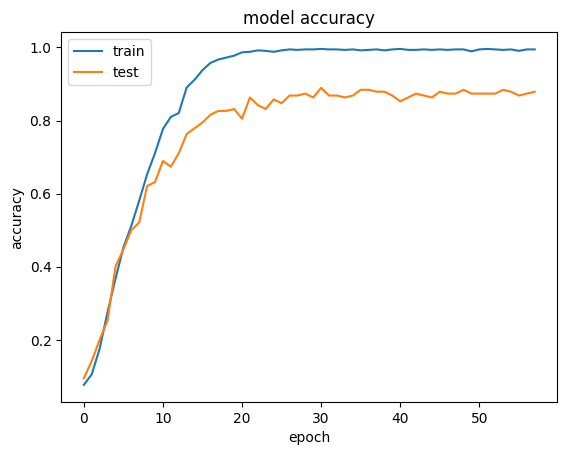

In [27]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [28]:
y_test1=np.argmax(y_test, axis=1)

y_pred_saved = saved_model.predict(X_test)
y_pred_saved=np.argmax(y_pred_saved,axis=1)

6/6 [==============================] - 6s 956ms/step


In [29]:
from sklearn import metrics
print(metrics.classification_report(y_test1,y_pred_saved))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.69      1.00      0.82         9
           2       1.00      1.00      1.00        10
           3       1.00      0.75      0.86         8
           4       0.78      1.00      0.88         7
           5       1.00      0.56      0.71         9
           6       0.70      1.00      0.82         7
           7       1.00      0.50      0.67        10
           8       0.78      0.88      0.82         8
           9       0.82      0.90      0.86        10
          10       1.00      1.00      1.00        11
          11       0.73      0.92      0.81        12
          12       0.71      0.71      0.71         7
          13       1.00      1.00      1.00         9
          14       0.92      0.86      0.89        14
          15       0.89      1.00      0.94        16
          16       1.00      1.00      1.00         7
          17       0.80    

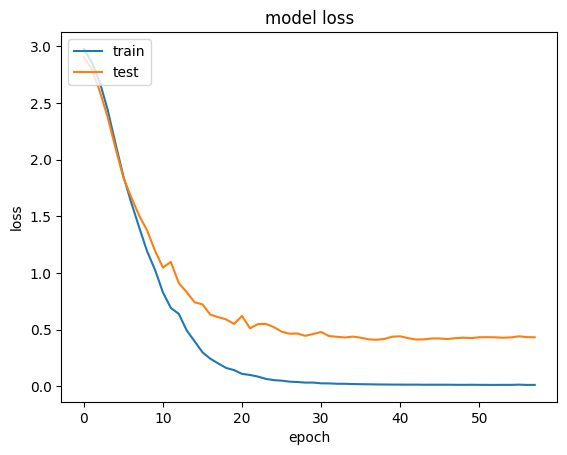

In [30]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()